In [43]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import ward, dendrogram
import glob

In [44]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vidya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vidya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
# Understanding the number of instances per class
path = "C:/Users/vidya/Documents/"
for sport in os.listdir(path + "bbcsport"):
    print(str(len(os.listdir(path + "bbcsport/" + sport))) + " " + sport)

101 athletics
124 cricket
265 football
147 rugby
100 tennis


In [46]:
ranks = []
for i in range(1, len(data)+1):
    ranks.append(i)
    
len(ranks)

737

In [47]:
# Extracting labels for corresponsing documents
label = []
files = glob.glob(os.path.join(path + "bbcsport/" + sport, "*.txt"))
df = pd.DataFrame()
for sport in os.listdir(path + "bbcsport"):
    for file in (os.listdir(path + "bbcsport/" + sport)):
        lb = sport
        label.append(lb)

len(label)

737

In [48]:
# Extracting document texts into an array
data = []
title = []
all_files = glob.glob('C:/Users/vidya/Documents/bbcsport/*/*.txt')
df = pd.DataFrame()
for file in all_files:
    with open(file, "r") as f:
        line = f.readline()
        title.append(line)
        
        text = f.read()
        data.append(text)

len(title)
len(data)

737

In [49]:
# Creating a dataframe for document text with their labels. Just in case if we need it in future. 
df = pd.DataFrame(columns= ['rank', 'title', 'text', 'label'])
df['rank'] = ranks
df['title']= title
df['text']= data
df['label']= label
df

,rank,title,text,label
0,1,Claxton hunting first major medal\n,\nBritish hurdler Sarah Claxton is confident s...,athletics
1,2,O'Sullivan could run in Worlds\n,\nSonia O'Sullivan has indicated that she woul...,athletics
2,3,Greene sets sights on world title\n,\nMaurice Greene aims to wipe out the pain of ...,athletics
3,4,IAAF launches fight against drugs\n,\nThe IAAF - athletics' world governing body -...,athletics
4,5,"Dibaba breaks 5,000m world record\n",\nEthiopia's Tirunesh Dibaba set a new world r...,athletics
...,...,...,...,...
732,733,Agassi into second round in Dubai\n,\nFourth seed Andre Agassi beat Radek Stepanek...,tennis
733,734,Mauresmo fights back to win title\n,\nWorld number two Amelie Mauresmo came from a...,tennis
734,735,Federer wins title in Rotterdam\n,\nWorld number one Roger Federer won the World...,tennis
735,736,GB players warned over security\n,\nBritain's Davis Cup players have been warned...,tennis


In [50]:
# Loading english stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [51]:
# loading NLTK's Stemmer
stemmer = SnowballStemmer("english")

In [52]:
# Both these functions to create a dictionary which becomes important in case if we want to use stems 
# for an algorithm, but later convert stems back to their full words for presentation purposes.

In [53]:
# Defining a tokenizer and stemmer which returns the set of stems in the text that it is passed
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [54]:
# Using the stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies:
# one stemmed and one only tokenized. 
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [55]:
vocab_stemmed = []
vocab_tokenized = []
for i in data:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'data', tokenize/stem
    vocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    vocab_tokenized.extend(allwords_tokenized)

In [56]:
vocab_frame = pd.DataFrame({'words': vocab_tokenized}, index = vocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 247890 items in vocab_frame


In [57]:
vocab_frame.head()

,words
british,british
hurdler,hurdler
sarah,sarah
claxton,claxton
is,is


In [58]:
# Defining term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the data list into a
# tf-idf matrix.

# This is a sport dataset, therefore there are many sports domain specific words which are occurring frequently and they are 
# not included in the english corpus stopwords. I initially tried removing domain-specific stopwords bt later realized that we
# can change the max_df frequency threshold which is the same method i wanted to use to remove the domain specific stopwords.

tfidf_vectorizer = TfidfVectorizer(max_df=0.6, max_features=300000,
                                 min_df=0.1, stop_words= stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,5))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(data) #fit the vectorizer to data
print(tfidf_matrix.shape)

C:\Users\vidya\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 5.88 s
(737, 260)


In [59]:
terms = tfidf_vectorizer.get_feature_names()

In [60]:
# Computing cosine distance using Cosine similarity between the documents
dist = 1 - cosine_similarity(tfidf_matrix)

In [61]:
# K-Means Clustering
num_clusters = 10
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

Wall time: 457 ms


In [62]:
import joblib
joblib.dump(km, 'doc_cluster.pkl')
# loading from the pickle
# km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [63]:
# adding a new column 'cluster' to the 'df' data frame
df['cluster'] = clusters

In [64]:
df

,rank,title,text,label,cluster
0,1,Claxton hunting first major medal\n,\nBritish hurdler Sarah Claxton is confident s...,athletics,1
1,2,O'Sullivan could run in Worlds\n,\nSonia O'Sullivan has indicated that she woul...,athletics,4
2,3,Greene sets sights on world title\n,\nMaurice Greene aims to wipe out the pain of ...,athletics,1
3,4,IAAF launches fight against drugs\n,\nThe IAAF - athletics' world governing body -...,athletics,5
4,5,"Dibaba breaks 5,000m world record\n",\nEthiopia's Tirunesh Dibaba set a new world r...,athletics,1
...,...,...,...,...,...
732,733,Agassi into second round in Dubai\n,\nFourth seed Andre Agassi beat Radek Stepanek...,tennis,9
733,734,Mauresmo fights back to win title\n,\nWorld number two Amelie Mauresmo came from a...,tennis,9
734,735,Federer wins title in Rotterdam\n,\nWorld number one Roger Federer won the World...,tennis,9
735,736,GB players warned over security\n,\nBritain's Davis Cup players have been warned...,tennis,5


In [65]:
sports = { 'title': title, 'rank': ranks, 'text': data, 'cluster': clusters, 'label': label }
frame = pd.DataFrame(sports, index = [clusters] , columns = ['rank', 'text', 'title', 'cluster', 'label'])

In [66]:
frame.head()

,rank,text,title,cluster,label
1,1,\nBritish hurdler Sarah Claxton is confident s...,Claxton hunting first major medal\n,1,athletics
4,2,\nSonia O'Sullivan has indicated that she woul...,O'Sullivan could run in Worlds\n,4,athletics
1,3,\nMaurice Greene aims to wipe out the pain of ...,Greene sets sights on world title\n,1,athletics
5,4,\nThe IAAF - athletics' world governing body -...,IAAF launches fight against drugs\n,5,athletics
1,5,\nEthiopia's Tirunesh Dibaba set a new world r...,"Dibaba breaks 5,000m world record\n",1,athletics


In [67]:
frame['cluster'].value_counts() #number of documents per cluster (clusters from 0 to 9)

5    117
6    107
3     93
4     88
9     84
1     68
2     56
0     55
7     40
8     29
Name: cluster, dtype: int64

In [68]:
grouped = frame['rank'].groupby(frame['cluster']) #groupby cluster for aggregation purposes
grouped.mean()

cluster
0    357.145455
1     52.014706
2    398.107143
3    210.784946
4    541.272727
5    455.076923
6    364.803738
7    160.050000
8    108.275862
9    683.619048
Name: rank, dtype: float64

In [69]:
# The following block is to understand the topped words in the clusters. These topped words will be used to name the clusters.
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for heading in frame.loc[i]['title'].values.tolist():
        print(' %s,' % heading, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'chelsea', b'arsenal', b'leagues', b'premiership', b'united', b'boss',

Cluster 0 titles: Gerrard plays down European hopes
, Duff ruled out of Barcelona clash
, Bridge could miss rest of season
, Robben sidelined with broken foot
, England's defensive crisis grows
, Premier League planning Cole date
, Chelsea denied by James heroics
, Chelsea ridiculed over complaint
, Mourinho defiant on Chelsea form
, Coach Ranieri sacked by Valencia
, Cole faces lengthy injury lay-off
, Robben plays down European return
, Adriano's Chelsea link rejected
, FA decides not to punish Mourinho
, Cudicini misses Carling Cup final
, Beattie return calms attack fears
, Thompson says Gerrard should stay
, Desailly backs Blues revenge trip
, Desailly backs Blues revenge trip
, Mourinho expects fight to finish
, Cup holders Man Utd visit Everton
, Redknapp's Saints face Pompey tie
, FA probes crowd trouble
, Chelsea sack Mutu
, Wenger offers Mutu hope
, Mutu to hold t

Cluster 6 words: b'club', b'united', b'player', b'want', b'management', b'leagues',

Cluster 6 titles: Event devised to nurture athletes
, ICC to press on with Dubai switch
, Van Nistelrooy set to return
, Ronaldo considering new contract
, Parry firm over Gerrard
, Giggs handed Wales leading role
, Bosvelt optimistic over new deal
, Sociedad set to rescue Mladenovic
, Parry relishes Anfield challenge
, Parry puts Gerrard 'above money'
, Bees handed potential Man Utd tie
, Ferdinand casts doubt over Glazer
, McCall earns Tannadice reprieve
, Weir poised for Sunderland move
, Newry to fight cup exit in courts
, Israeli club look to Africa
, Highbury tunnel players in clear
, Wenger handed summer war chest
, Palace threat over Cantona masks
, Ferguson fears Milan cutting edge
, Rush future at Chester uncertain
, Reyes tricked into Real admission
, Souness eyes summer move for Owen
, Stam spices up Man Utd encounter
, Hodgson relishes European clashes
, Ajax refuse to rule out Jol move
, 

In [70]:
MDS()
# convert two components as we're plotting points in a 2D plane. "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]
print()

In [71]:
cluster_colors = {0: '#9F1D10', 1: '#F7A520', 2: '#F7F620', 3: '#96F720', 4: '#20F773',
                 5: '#20F5F7', 6: '#206AF7', 7: '#8220F7', 8: '#F720EC', 9: '#F7209F'}
#set up cluster names using a dict
cluster_names = {0: 'cricket, test , tour', 
                 1: 'club, player, football', 
                 2: 'race, olympic, european', 
                 3: 'chelsea, united, arsenal', 
                 4: 'england, wales, ireland',
                 5: 'olympic, test, missed', 
                 6: 'goal, minutes, scored', 
                 7: 'rugby, player, england', 
                 8: 'opening, setting, played', 
                 9: 'ball, run, four'}

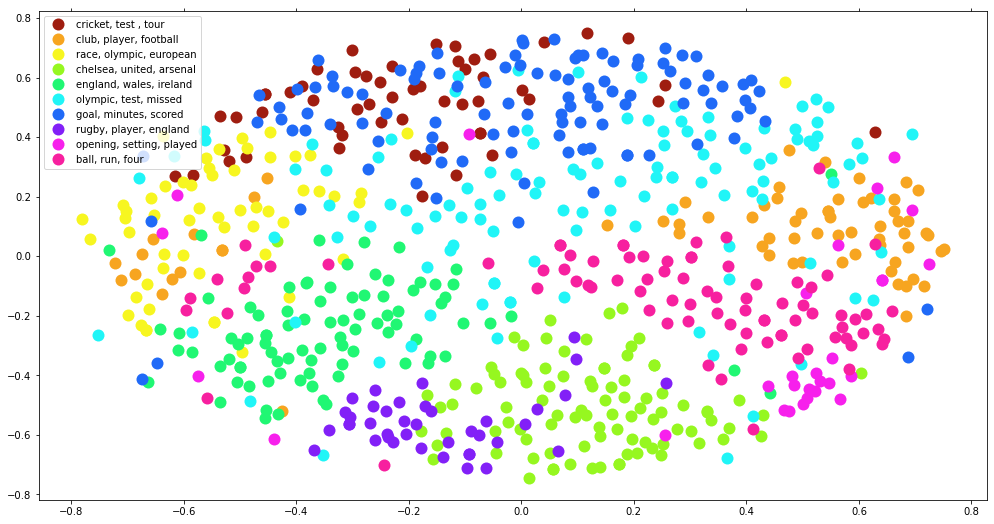

In [72]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df2 = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=title)) 

#group by cluster
groups = df2.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

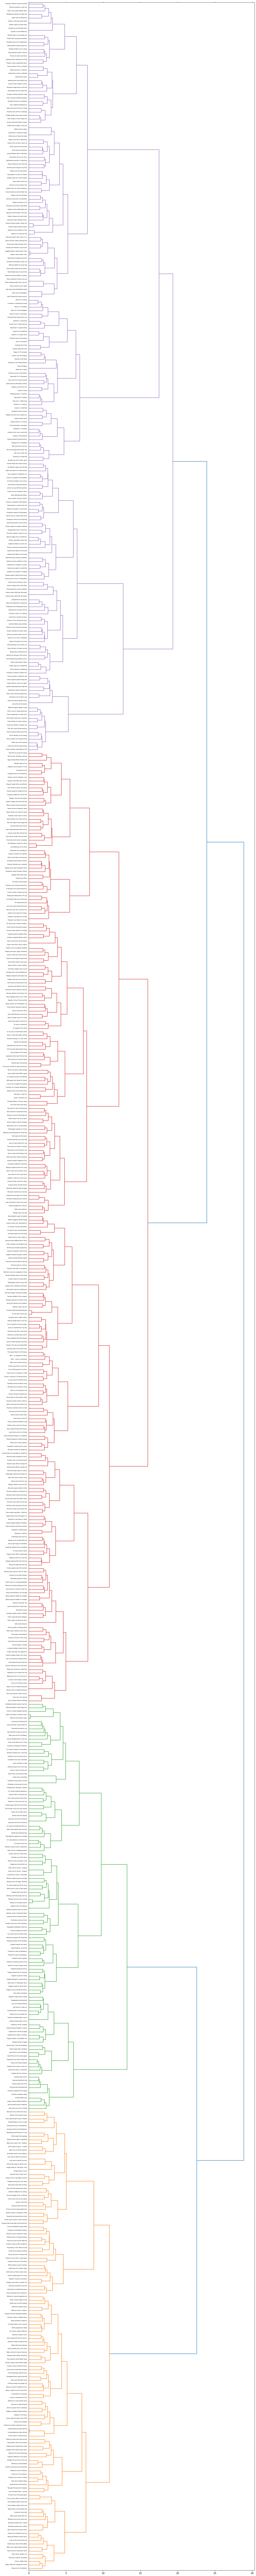

In [73]:
# As shown in the above diagram, I believe there is a huge overlap among the clusters as the inter-centroid distance is very
# less. Due to which I believe the presence of the hierarchy among the news documents. Let's do some hierarchial clustering.

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 150)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=title);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

In [ ]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [ ]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [ ]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in synopses]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

In [ ]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
%time lda = models.LdaModel(corpus, num_topics=5, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=10000, 
                            passes=100)

In [ ]:
lda.show_topics()

In [ ]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()